In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocessed

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Membaca file Excel
data_raw = pd.read_excel(
    "E:/code/project-list/bert-hfacs/data/raw/subclass_hfacs_dataset.xlsx",
    sheet_name="Sheet1",
)

In [4]:
# Fungsi untuk membersihkan teks
def clean_text(text, remove_stopwords=False):
    text = text.lower()  # Mengubah teks menjadi huruf kecil
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Menghapus URL
    text = re.sub(r'\S+@\S+', '', text)  # Menghapus email
    text = re.sub(r'<.*?>', '', text)  # Menghapus tag HTML
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    text = re.sub(r'[^\x00-\x7f]',r'', text)  # Menghapus karakter khusus
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih

    if remove_stopwords:
        text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [3]:
def preprocessed (data):
    # Karena dataset didapatkan dari hasil hfacs manual dengan Pak Ridwan maka di drop kolom "Alasan"
    data = data.drop(columns=["Alasan"])

    # Mengganti simbol2
    data = data.replace("-", 0)
    data = data.replace("?", 0)
    data = data.replace("--", 0)
    data = data.fillna(0)

    # Mengganti tipe data
    data["ER (LVL1)"] = data["ER (LVL1)"].astype(float)
    data["VIO (LVL1)"] = data["VIO (LVL1)"].astype(float)
    data["EF (LVL2)"] = data["EF (LVL2)"].astype(float)
    data["CO (LVL2)"] = data["CO (LVL2)"].astype(float)
    data["PF (LVL2)"] = data["PF (LVL2)"].astype(float)

    data["TARGET_LIST"] = data[
        ["ER (LVL1)", "VIO (LVL1)", "EF (LVL2)", "CO (LVL2)", "PF (LVL2)"]
    ].values.tolist()

    data = data.drop(
        columns=["ER (LVL1)", "VIO (LVL1)", "EF (LVL2)", "CO (LVL2)", "PF (LVL2)"]
    )

    data = data.rename(columns={"Teks": "text"})
    data = data.rename(columns={"TARGET_LIST": "label"})

    # Define the mapping dictionary for converting the one-hot encoded labels to their respective categories
    label_mapping = {
        '[1.0, 0.0, 0.0, 0.0, 0.0]': 'ER',
        '[0.0, 1.0, 0.0, 0.0, 0.0]': 'VIO',
        '[0.0, 0.0, 1.0, 0.0, 0.0]': 'EF',
        '[0.0, 0.0, 0.0, 1.0, 0.0]': 'CO',
        '[0.0, 0.0, 0.0, 0.0, 1.0]': 'PF'
    }

    # Convert the TARGET_LIST column to string for mapping
    data['label'] = data['label'].astype(str)

    # Apply the label mapping
    data['label'] = data['label'].map(label_mapping)

    data = data.dropna()
    data.to_csv(
        "E:/code/project-list/bert-hfacs/data/interim/data_preprocessed.csv",
        index=False,
    )

    return data


In [4]:
data_preprocessed = preprocessed(data_raw)

C:\Users\USER\AppData\Local\Temp\ipykernel_4116\4221560159.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace("?", 0)
C:\Users\USER\AppData\Local\Temp\ipykernel_4116\4221560159.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace("--", 0)


In [5]:
# Menghitung jumlah sampel di setiap kelas pada kolom 'label'
label_counts = data_preprocessed['label'].value_counts()

# Menampilkan jumlah sampel per kelas
print(label_counts)

label
ER     64
VIO    53
EF     51
PF     27
CO     21
Name: count, dtype: int64


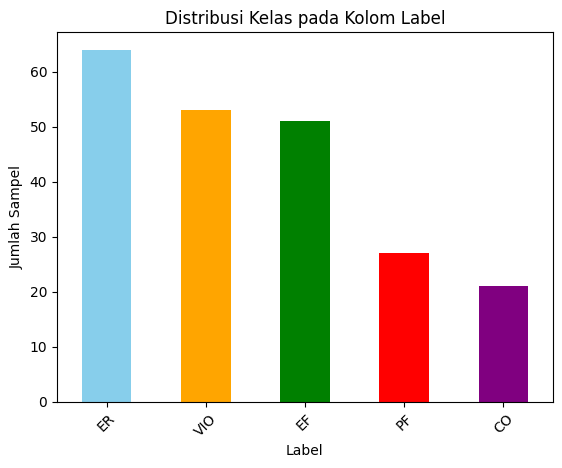

In [6]:
import matplotlib.pyplot as plt

colors = ['skyblue', 'orange', 'green', 'red', 'purple']

# Plot distribusi kelas
label_counts.plot(kind='bar', color=colors)
plt.xlabel('Label')
plt.ylabel('Jumlah Sampel')
plt.title('Distribusi Kelas pada Kolom Label')
plt.xticks(rotation=45)
plt.show()

In [7]:
def split_data(data):
    # train test split
    train_dataset, test_dataset = train_test_split(
        data, test_size=0.2, stratify=data['label'], random_state=1
    )

    print(f"Train shape: {train_dataset.shape}")
    print(f"Test shape: {test_dataset.shape}")

    # export to csv
    train_dataset.to_csv(
        "E:/code/project-list/bert-hfacs/data/processed/train.csv",
        index=False,
    )
    test_dataset.to_csv(
        "E:/code/project-list/bert-hfacs/data/processed/test.csv",
        index=False,
    )

    return train_dataset, test_dataset

In [8]:
train_dataset, test_dataset = split_data(data_preprocessed)

Train shape: (172, 2)
Test shape: (44, 2)


In [9]:
label_counts = train_dataset['label'].value_counts()

In [10]:
print(label_counts)

label
ER     51
VIO    42
EF     41
PF     21
CO     17
Name: count, dtype: int64


In [ ]:
####### Augmentasi Chatgpt manual ########
'''
import pandas as pd

# Membaca file csv
data_train = pd.read_csv(
    "/content/drive/MyDrive/code/subclass_hfacs_dataset_1to1_train_aug_chatgpt.csv",
    engine="python",
)

data_test = pd.read_csv(
    "/content/drive/MyDrive/code/subclass_hfacs_dataset_1to1_test.csv",
    engine="python",
)

data_train = data_train.drop(columns=['Unnamed: 0'])

data_train = data_train.rename(columns={"TEXT": "text"})
data_train = data_train.rename(columns={"TARGET_LIST": "label"})

data_test = data_test.rename(columns={"TEXT": "text"})
data_test = data_test.rename(columns={"TARGET_LIST": "label"})

In [11]:
import torch
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

GPU is available


In [12]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class HfacsDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {"ER": 0, "VIO": 1, "EF": 2, "CO": 3, "PF": 4}
    INDEX2LABEL = {0: "ER", 1: "VIO", 2: "EF", 3: "CO", 4: "PF"}
    NUM_LABELS = 5

    def load_dataset(self, path):
        # Load dataset
        dataset = pd.read_csv(path)
        dataset["label"] = dataset["label"].apply(lambda sen: self.LABEL2INDEX[sen])
        return dataset

    def __init__(
        self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs
    ):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        text, label = self.data.loc[index, "text"], self.data.loc[index, "label"]
        subwords = self.tokenizer.encode(
            text, add_special_tokens=not self.no_special_token
        )
        return np.array(subwords), np.array(label), text

    def __len__(self):
        return len(self.data)

In [13]:
class HfacsDataloader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(HfacsDataloader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.full((batch_size, 1), -100, dtype=np.int64)

        seq_list = []
        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i, : len(subwords)] = subwords
            mask_batch[i, : len(subwords)] = 1
            label_batch[i] = label

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, label_batch, seq_list

In [14]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def hfacs_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average="macro")
    metrics["REC"] = recall_score(list_label, list_hyp, average="macro")
    metrics["PRE"] = precision_score(list_label, list_hyp, average="macro")
    return metrics

In [15]:
import torch

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])

    return loss, list_hyp, list_label

In [17]:
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('E:/code/project-list/bert-hfacs/models/models--indobenchmark--indobert-base-p1/snapshots/c2cd0b51ddce6580eb35263b39b0a1e5fb0a39e2')
config = BertConfig.from_pretrained('E:/code/project-list/bert-hfacs/models/models--indobenchmark--indobert-base-p1/snapshots/c2cd0b51ddce6580eb35263b39b0a1e5fb0a39e2')
config.num_labels = HfacsDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('E:/code/project-list/bert-hfacs/models/models--indobenchmark--indobert-base-p1/snapshots/c2cd0b51ddce6580eb35263b39b0a1e5fb0a39e2', config=config)

e:\code\project-list\bert-hfacs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at E:/code/project-list/bert-hfacs/models/models--indobenchmark--indobert-base-p1/snapshots/c2cd0b51ddce6580eb35263b39b0a1e5fb0a39e2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
train_dataset_path = 'E:/code/project-list/bert-hfacs/data/processed/train.csv'
test_dataset_path = 'E:/code/project-list/bert-hfacs/data/processed/test.csv'

In [22]:
train_dataset = HfacsDataset(train_dataset_path, tokenizer, lowercase=True)
test_dataset = HfacsDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = HfacsDataloader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=8, shuffle=True, pin_memory=True)
test_loader = HfacsDataloader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=8, shuffle=False, pin_memory=True)

In [23]:
w2i, i2w = HfacsDataset.LABEL2INDEX, HfacsDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'ER': 0, 'VIO': 1, 'EF': 2, 'CO': 3, 'PF': 4}
{0: 'ER', 1: 'VIO', 2: 'EF', 3: 'CO', 4: 'PF'}


In [24]:
import torch
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=5e-6)
model = model.cuda()

In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
from tqdm import tqdm

# Train
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = hfacs_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import torch

# Misalkan model adalah instance dari model Anda
torch.save(model.state_dict(), 'model3.pth')

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_with_optimizer3.pth')

## Evaluate

In [ ]:
from tqdm import tqdm

In [ ]:
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
config = BertConfig.from_pretrained('indolem/indobert-base-uncased')
config.num_labels = HfacsDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indolem/indobert-base-uncased', config=config)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/code/model3.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
model = model.cuda()

In [ ]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Calculate train metric
metrics = hfacs_metrics_fn(list_hyp, list_label)
print("{}".format(metrics_to_string(metrics)))


# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

100%|██████████| 2/2 [00:00<00:00,  2.81it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ACC:0.39 F1:0.23 REC:0.29 PRE:0.23
    index label
0       0    ER
1       1    EF
2       2    EF
3       3    EF
4       4    ER
5       5    ER
6       6    ER
7       7    ER
8       8    ER
9       9    ER
10     10    ER
11     11    ER
12     12    ER
13     13    ER
14     14   VIO
15     15    ER
16     16    EF
17     17    ER
18     18    ER
19     19    EF
20     20    ER
21     21    EF
22     22    ER
23     23    EF
24     24    ER
25     25    ER
26     26    EF
27     27    ER
28     28    ER
29     29    ER
30     30    ER
31     31    ER
32     32   VIO
33     33    ER
34     34    ER
35     35    ER
36     36    EF
37     37    EF
38     38    EF
39     39    ER
40     40    ER
41     41   VIO
42     42    ER
43     43    ER
